# 2.4 Implementing Gaussian process in Python

## 2.4.1 Setting up the training data

In [1]:
import torch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

In [2]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [3]:
torch.manual_seed(0)
train_x = torch.rand(size=(3, 1)) * 6 - 3
train_y = forrester_1d(train_x)

train_x, train_y

(tensor([[-0.0225],
         [ 1.6093],
         [-2.4691]]),
 tensor([0.8228, 2.1909, 1.0872]))

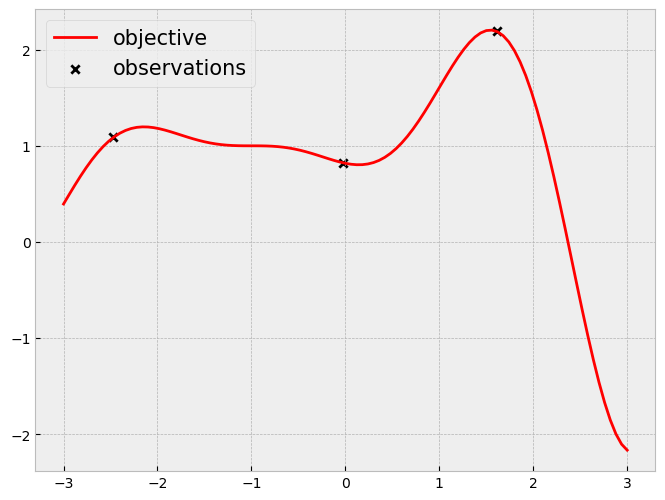

In [4]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

plt.figure(figsize=(8, 6))

plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

plt.legend(fontsize=15);

## 2.4.2 Implementing a Gaussian process class

In [5]:
import gpytorch


class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 2.4.3 Making predictions with a Gaussian process

In [6]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(None, None, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## 2.4.4 Visualizing predictions by a Gaussian process

In [7]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(0)
    samples = predictive_distribution.sample(torch.Size([5]))

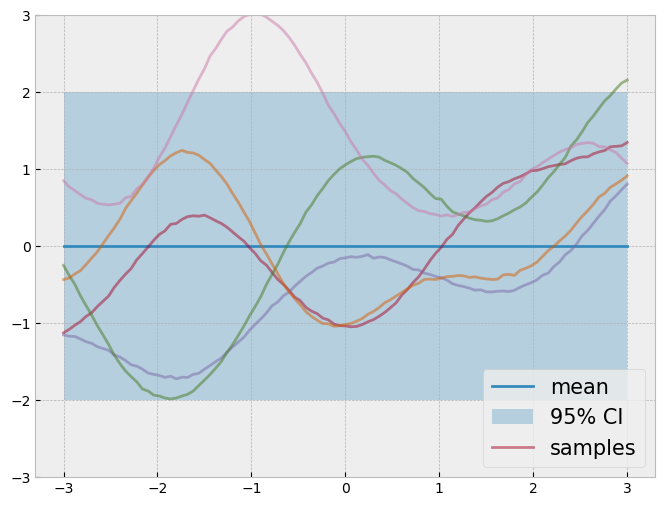

In [8]:
plt.figure(figsize=(8, 6))

plt.plot(xs, predictive_mean.detach(), label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.ylim(-3, 3)

plt.legend(fontsize=15);

In [9]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [10]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(0)
    samples = predictive_distribution.sample(torch.Size([5]))

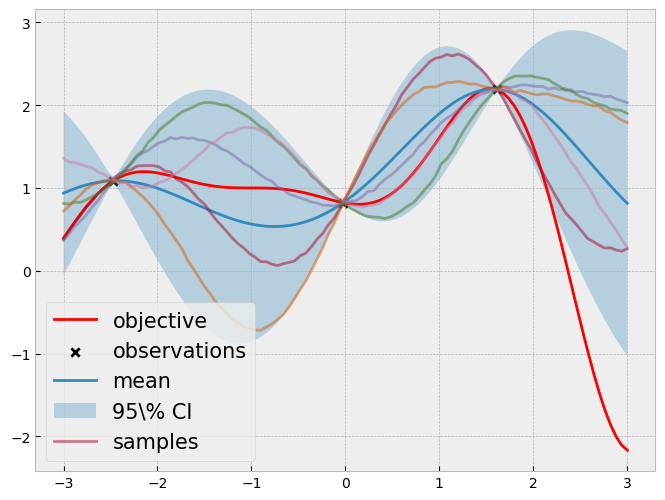

In [11]:
plt.figure(figsize=(8, 6))

plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

plt.plot(xs, predictive_mean, label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.legend(fontsize=15);

## Going beyond one-dimensional objective functions

In [12]:
train_x = torch.tensor([[0.0, 0.0], [1.0, 2.0], [-1.0, 1.0]])

train_y = torch.tensor([0.0, -1.0, 0.5])

In [13]:
grid_x = torch.linspace(-3, 3, 101)

grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten()]).transpose(-1, -2)

In [14]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [15]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev

In [16]:
plt.rcParams["image.cmap"] = "magma"

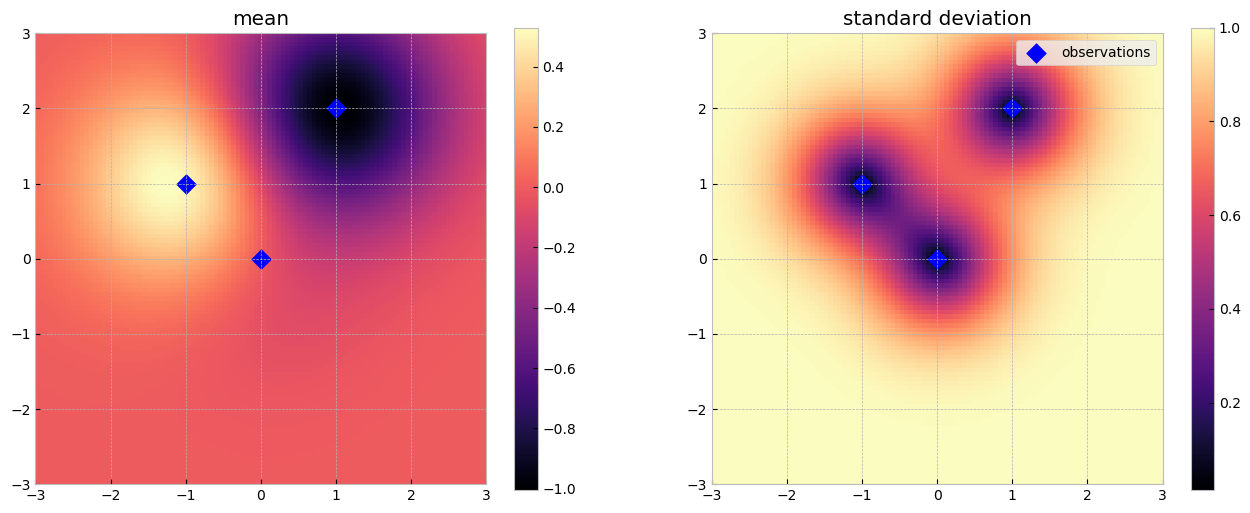

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
)
plt.colorbar(c, ax=ax[0])

ax[0].scatter(train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100)

ax[0].set_title("mean")

c = ax[1].imshow(
    predictive_stddev.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
)
plt.colorbar(c, ax=ax[1])

ax[1].scatter(
    train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100, label="observations"
)

ax[1].set_title("standard deviation")

ax[1].legend()

plt.show()